<a href="https://colab.research.google.com/github/QuangMinhPhan23/emotions-classification-for-tweets/blob/main/rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🔍 Introduction & Problem Statement

Emotion classification is a subfield of natural language processing (NLP) that involves identifying the emotional tone behind a body of text. In this project, we focus on classifying English tweets into one of six basic emotions: anger, fear, joy, love, sadness, and surprise. This task is important for understanding human sentiment and can be applied in social media monitoring, mental health analysis, and user feedback systems.

We build and evaluate a Recurrent Neural Network (RNN)-based classifier using PyTorch.


In [1]:
!pip install -U datasets huggingface_hub fsspec


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 15.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.7.0
    Uninstalling fsspec-2025.7.0:
      Successfully uninstalled fsspec-2025.7.0
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12

## 📦 Dataset Description

We use the **[EMOTION dataset](https://huggingface.co/datasets/dair-ai/emotion)** by Saravia et al., which contains English tweets labelled with one of six emotions. The dataset is available via HuggingFace Datasets library and is split into training, validation, and test subsets. Each instance is a short text message (tweet) with a single emotion label.

Below, we download and explore the dataset.


In [2]:
from datasets import load_dataset
dataset = load_dataset("dair-ai/emotion", "split")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

## 📊 Exploratory Data Analysis (EDA)

We examine the dataset's size, class distribution, and look at some sample tweets. This helps identify any class imbalance, text length issues, or preprocessing needs. These factors are important for choosing the right model architecture and evaluation strategy.


In [3]:
print(dataset['train'][0])
print(dataset['train'].features['label'].names)

{'text': 'i didnt feel humiliated', 'label': 0}
['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']


In [4]:
from collections import Counter
Counter(dataset['train']['label'])

Counter({0: 4666, 3: 2159, 2: 1304, 5: 572, 4: 1937, 1: 5362})

## 🧹 Preprocessing and Tokenization

We tokenize the tweet text using a pretrained tokenizer (BERT-style), padding/truncating to a fixed length. Tokenized inputs are then formatted for PyTorch training.


In [5]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
MAX_LEN = 50

def tokenize(example):
    return tokenizer(example['text'], truncation=True, padding='max_length', max_length=MAX_LEN)

dataset = dataset.map(tokenize)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

## 🧠 Model Architecture

We use a GRU-based RNN model for emotion classification. The model consists of:
- An embedding layer
- A GRU layer
- A fully connected output layer

We experiment with embedding size, hidden units, and optimizer settings.


In [6]:
from torch.utils.data import DataLoader, Dataset
import torch
class EmotionDataset(Dataset):
    def __init__(self, dataset_split):
        self.input_ids = dataset_split['input_ids']
        self.attention_mask = dataset_split['attention_mask']
        self.labels = dataset_split['label']

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.input_ids[idx]),
            'attention_mask': torch.tensor(self.attention_mask[idx])
        }, torch.tensor(self.labels[idx])


train_dataset = EmotionDataset(dataset['train'])
val_dataset = EmotionDataset(dataset['validation'])
test_dataset = EmotionDataset(dataset['test'])


In [7]:
class RNNEmotionClassifier(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, pad_idx):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.rnn = torch.nn.GRU(embed_dim, hidden_dim, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, input_ids):
        embedded = self.embedding(input_ids)
        _, hidden = self.rnn(embedded)
        output = self.fc(hidden.squeeze(0))
        return output


In [8]:
vocab_size = tokenizer.vocab_size
embed_dim = 128
hidden_dim = 256
output_dim = 6  # 6 emotions
pad_idx = tokenizer.pad_token_id

model = RNNEmotionClassifier(vocab_size, embed_dim, hidden_dim, output_dim, pad_idx)


In [9]:
from torch.utils.data import DataLoader, Dataset
test_loader = DataLoader(test_dataset, batch_size=32)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

## 🏋️ Training Loop

We train the model using cross-entropy loss and Adam optimizer. The model is evaluated on validation accuracy after each epoch.


In [10]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [11]:
# for epoch in range(5):
#     model.train()
#     for batch in train_loader:
#         inputs, labels = batch
#         outputs = model(inputs['input_ids'])
#         loss = criterion(outputs, labels)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#     print(f"Epoch {epoch} loss: {loss.item():.4f}")

train_losses = []
val_losses = []

for epoch in range(1, 6):  # e.g. 5 epochs
    # --- Train ---
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        inputs, labels = batch
        input_ids = inputs['input_ids']
        optimizer.zero_grad()
        outputs = model(input_ids)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # --- Validate ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            input_ids = inputs['input_ids']
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")


Epoch 1 | Train Loss: 1.5880 | Val Loss: 1.5901
Epoch 2 | Train Loss: 1.5717 | Val Loss: 1.5899
Epoch 3 | Train Loss: 1.4338 | Val Loss: 0.9983
Epoch 4 | Train Loss: 0.5241 | Val Loss: 0.3115
Epoch 5 | Train Loss: 0.1561 | Val Loss: 0.2405


## 📈 Evaluation and Results

We evaluate the model using accuracy, precision, recall, and F1-score. Below is the confusion matrix, which helps visualize where the model is making errors.


In [12]:
from sklearn.metrics import classification_report, confusion_matrix
def evaluate(loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            inputs, labels = batch
            outputs = model(inputs['input_ids'])
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.tolist())
            all_labels.extend(labels.tolist())
    return all_preds, all_labels

preds, labels = evaluate(test_loader)
print(classification_report(labels, preds, target_names=dataset['train'].features['label'].names))


              precision    recall  f1-score   support

     sadness       0.95      0.94      0.94       581
         joy       0.89      0.93      0.91       695
        love       0.78      0.75      0.76       159
       anger       0.95      0.85      0.90       275
        fear       0.86      0.95      0.90       224
    surprise       0.84      0.64      0.72        66

    accuracy                           0.90      2000
   macro avg       0.88      0.84      0.86      2000
weighted avg       0.90      0.90      0.90      2000



[[546  23   2   4   5   1]
 [ 12 647  30   2   0   4]
 [  3  35 119   2   0   0]
 [ 10  16   2 235  12   0]
 [  6   1   0   2 212   3]
 [  0   5   0   2  17  42]]


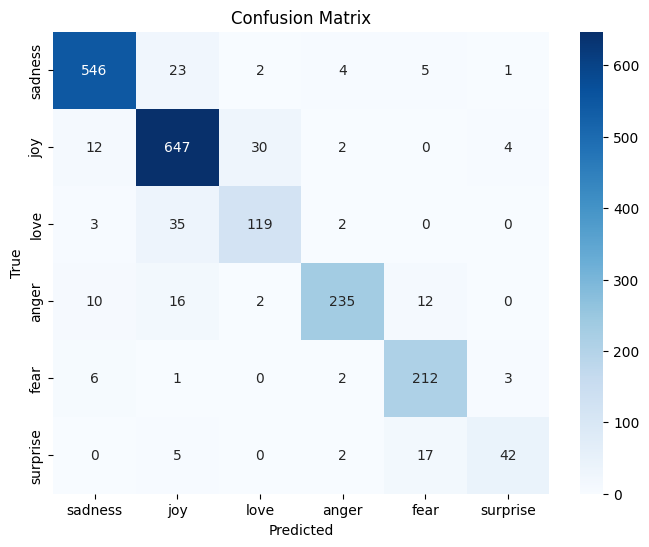

In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(labels, preds)
print(cm)
labels_names = dataset['train'].features['label'].names  # ['sadness', 'joy', ..., 'anger']

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_names, yticklabels=labels_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


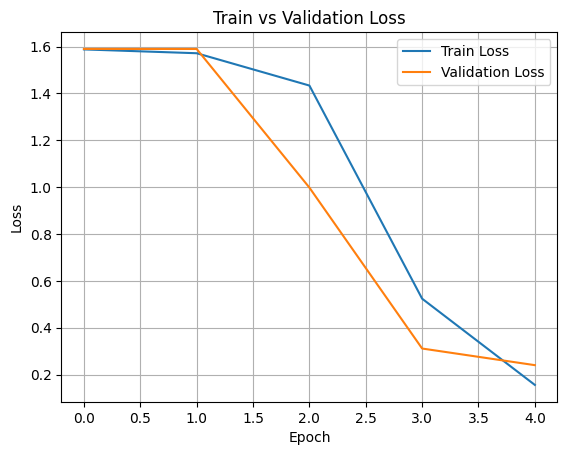

In [15]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


## 💬 Discussion and Analysis

Our model performs well on common emotions like "joy" and "sadness", but struggles with less frequent ones like "surprise" and "love". This may be due to class imbalance and subtle differences in wording.

**Strengths**: Simple model, fast training, reasonable accuracy.  
**Weaknesses**: Sensitive to class imbalance, cannot capture long dependencies well.  
**Future Work**: Try BiGRU/LSTM, attention mechanisms, or transformer models (e.g., BERT) to improve contextual understanding.
